# **Initialization**

In [89]:
import pandas, numpy, warnings, matplotlib.pyplot as plot
from typing import Literal, get_args

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import SGDRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

pandas.options.display.float_format = '{:.4f}'.format
warnings.filterwarnings('ignore')

random_state = 42
numpy.random.seed(random_state) 

# Data Extraction

label_key = 'Life ladder'

training_data = pandas.read_csv('data/train.csv')
testing_data = pandas.read_csv('data/test.csv')

features_training = training_data.drop(label_key, axis=1)
label_training = training_data[label_key]

features_testing = testing_data.drop(label_key, axis=1)
label_testing = testing_data[label_key]

imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

# Hyperparameters

tolerance = 1e-7
degrees = [1, 2, 3, 4]
max_iterations = 10000
alphas = [0.001, 0.005, 0.1]
eta0s = [0.001, 0.005, 0.01]
penalties = get_args(Literal['l2', 'l1', 'elasticnet'])

cross_validator  = KFold(n_splits=4, shuffle=True, random_state=random_state)

# **Cross Validation**

## SGD (Stochastic Gradient Descent) Regressor

In [90]:
results = []

for degree in degrees:
    for penalty in penalties:
        for alpha in alphas:
            for eta0 in eta0s:
                pipeline = Pipeline(
                    steps = [
                        ('imputer', imputer),
                        ('polynomial_features', PolynomialFeatures(degree, include_bias=False)),
                        ('scaler', scaler),                          
                        ('model', SGDRegressor(
                            penalty=penalty,
                            alpha=alpha,
                            eta0=eta0,
                            learning_rate='constant',
                            shuffle=True,
                            max_iter=max_iterations,  
                            tol=tolerance,
                            random_state=random_state
                            )
                        )
                    ]
                )

                rmse_values = -cross_val_score(
                    pipeline, 
                    features_training, 
                    label_training, 
                    cv=cross_validator, 
                    scoring='neg_root_mean_squared_error'
                )              

                results.append({
                    'penalty': penalty,
                    'alpha': alpha,
                    'eta0': eta0,
                    'learning_rate':'constant',
                    'mean_rmse': rmse_values.mean(),
                    'sd_rmse':  rmse_values.std(),
                    'degree': degree
                })
            
results = pandas.DataFrame(results).sort_values('mean_rmse').reset_index(drop=True)
optimal_configuration = results.iloc[0]

display(results)

,penalty,alpha,eta0,learning_rate,mean_rmse,sd_rmse,degree
0,l1,0.0050,0.0010,constant,0.5133,0.0300,4
1,l1,0.0010,0.0010,constant,0.5167,0.0307,3
2,l1,0.0050,0.0010,constant,0.5168,0.0291,3
3,elasticnet,0.0050,0.0010,constant,0.5184,0.0309,3
4,elasticnet,0.1000,0.0010,constant,0.5185,0.0312,4
...,...,...,...,...,...,...,...
103,l1,0.1000,0.0100,constant,2494482002364.3340,1335378862154.5066,4
104,l1,0.0050,0.0100,constant,2589115447629.6045,524403929638.2355,4
105,l1,0.0010,0.0100,constant,2594684209095.4116,210796807239.5464,4
106,l2,0.1000,0.0100,constant,2960835727109.3623,1002584724798.7885,4


## Closed-Form Solution (Ridge)

In [91]:
rmse_values = -cross_val_score(
                Pipeline(
                    steps = [
                        ('imputer', imputer),
                        ('polynomial_features', PolynomialFeatures(optimal_configuration['degree'], include_bias=False)),
                        ('scaler', scaler),  
                        ('model',Ridge(100))
                    ]
                ), 
                features_training, 
                label_training, 
                cv=cross_validator, 
                scoring='neg_root_mean_squared_error'
            )

print(f'RMSE Values: {numpy.round(rmse_values, 4)}')
print(f'Mean RMSE: {rmse_values.mean():.4f}')
print(f'Standard Deviation of RMSE: {rmse_values.std():.4f}')

RMSE Values: [0.5524 0.4931 0.487  0.4917]
Mean RMSE: 0.5061
Standard Deviation of RMSE: 0.0268


# **Graphical Representations**

## RMSE Over Degree

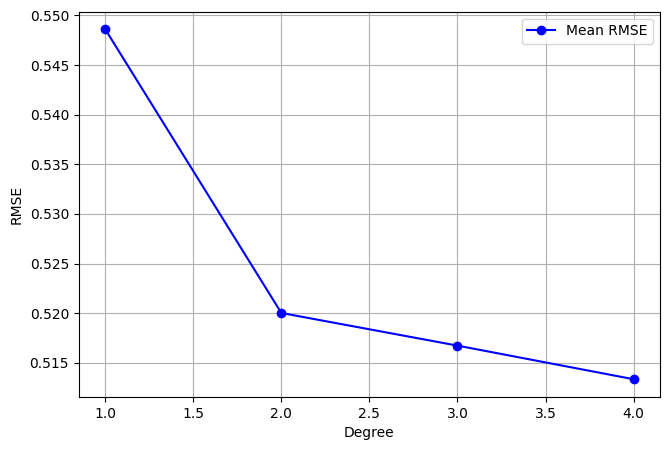

In [92]:
aggregated_results = results.groupby('degree')['mean_rmse'].min().reset_index()

plot.figure(figsize=(7.5, 5))
plot.plot(aggregated_results['degree'], aggregated_results['mean_rmse'], marker='o', linestyle='-', color='b', label='Mean RMSE')
plot.xlabel('Degree')
plot.ylabel('RMSE')
plot.grid(True)
plot.legend()
plot.show()

## Training and Validation Loss Over Epochs

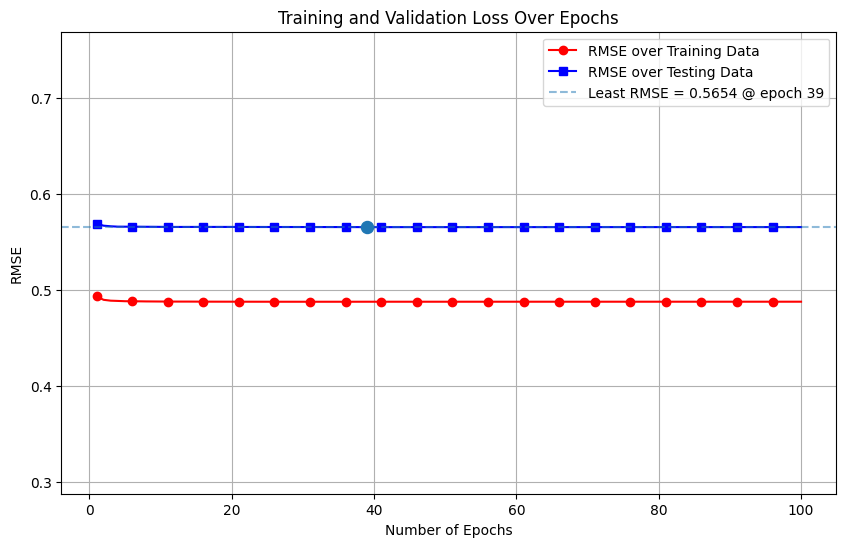

In [93]:
X_training, X_testing, y_training, y_testing = train_test_split(
    features_training, label_training, test_size=0.2, random_state=random_state
)

pipeline = Pipeline(
    steps=[
        ('imputer', imputer),
        ('polynomial_features', PolynomialFeatures(optimal_configuration['degree'], include_bias=False)),
        ('scaler', scaler), 
        ('model', SGDRegressor(
            penalty=optimal_configuration['penalty'],
            alpha=optimal_configuration['alpha'],
            eta0=optimal_configuration['eta0'],
            learning_rate='constant',
            shuffle=True,
            tol=tolerance,
            max_iter=max_iterations, 
            warm_start=True,
            random_state=random_state
        ))
    ]
)

errors_training, errors_testing = [], []
least_rmse = float('inf')
minimum_epochs = 0
epochs_count = 100

for epoch in range(1, epochs_count + 1):
    
    pipeline.fit(X_training, y_training)
    
    predictions_training = pipeline.predict(X_training)
    predictions_testing = pipeline.predict(X_testing)
    
    error_training = root_mean_squared_error(y_training, predictions_training)
    error_testing = root_mean_squared_error(y_testing, predictions_testing)
    
    errors_training.append(error_training)
    errors_testing.append(error_testing)
    
    if error_testing < least_rmse:
        least_rmse, minimum_epochs = error_testing, epoch

plot.figure(figsize=(10, 6))
x_axis = range(1, epochs_count + 1)
plot.plot(x_axis, errors_training, 'r-', marker='o', markevery=5, label='RMSE over Training Data')
plot.plot(x_axis, errors_testing, 'b-', marker='s', markevery=5, label='RMSE over Testing Data')

buffer = 0.2
plot.ylim(min(errors_training + errors_testing) - buffer, max(errors_training + errors_testing) + buffer)

plot.axhline(least_rmse, ls='--', alpha=0.5, label=f'Least RMSE = {least_rmse:.4f} @ epoch {minimum_epochs}')
plot.scatter([minimum_epochs], [least_rmse], s=75, zorder=2)

plot.xlabel('Number of Epochs')
plot.ylabel('RMSE')

plot.title('Training and Validation Loss Over Epochs')
plot.grid(True)
plot.legend()
plot.show()


# **Test Data Evaluation**

In [95]:
features_testing = testing_data.drop(label_key, axis=1)
label_testing = testing_data[label_key]

sgd_pipeline = Pipeline(
    steps=[
        ('imputer', imputer),
        ('polynomial_features', PolynomialFeatures(optimal_configuration['degree'], include_bias=False)),
        ('scaler', scaler), 
        ('model', SGDRegressor(
            penalty=optimal_configuration['penalty'],
            alpha=optimal_configuration['alpha'],
            eta0=optimal_configuration['eta0'],
            learning_rate='adaptive', # it's reactive - if the loss stops decreasing for a certain number of iterations, it divides the current learning rate by 5.
            shuffle=True,
            tol=tolerance,
            max_iter=max_iterations, 
            warm_start=True,
            random_state=random_state
        ))
    ]
)

sgd_pipeline.fit(features_training, label_training)
print(f'RMSE using SGD: {root_mean_squared_error(label_testing, sgd_pipeline.predict(features_testing))}')

ridge_pipeline = Pipeline(
    steps=[
        ('imputer', imputer),
        ('polynomial_features', PolynomialFeatures(optimal_configuration['degree'], include_bias=False)),
        ('scaler', scaler), 
        ('model', Ridge(100))
    ]
)

ridge_pipeline.fit(features_training, label_training)
print(f'RMSE using Ridge (Closed Form): {root_mean_squared_error(label_testing, ridge_pipeline.predict(features_testing))}')

RMSE using SGD: 0.5145299050747275
RMSE using Ridge (Closed Form): 0.5060890249118556
